# CatBoost

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatboostIpythonWidget

## Examine data

In [2]:
%%capture
df = pd.read_csv('merged.csv', sep='\t', error_bad_lines=False, header=0)

In [3]:
len(df)

387504

In [4]:
df.head()

,Unnamed: 0,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,...,phyloP100way_vertebrate,phyloP100way_vertebrate_rankscore,phyloP20way_mammalian,phyloP20way_mammalian_rankscore,phastCons100way_vertebrate,phastCons100way_vertebrate_rankscore,phastCons20way_mammalian,phastCons20way_mammalian_rankscore,SiPhy_29way_logOdds_rankscore,MIM_disease
0,0,1,949422,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,...,-0.676,0.05280,-0.119,0.11356,0.0,0.06329,0.001,0.04339,0.07229,"[MIM:616126]Immunodeficiency 38, with basal ga..."
1,1,1,949523,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,949597,C,T,NM_005101.3,synonymous,exon,p.Asp79Asp,80.7048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,949608,G,A,NM_005101.3,missense,exon,p.Ser83Asn,80.7048,...,-0.396,0.07279,-0.748,0.03458,0.0,0.06329,0.829,0.34619,0.40740,"[MIM:616126]Immunodeficiency 38, with basal ga..."
4,4,1,949696,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.dtypes

Unnamed: 0                                int64
chrom                                    object
inputPos                                  int64
inputRef                                 object
inputAlt                                 object
transcript                               object
codingEffect                             object
varLocation                              object
alt_pNomen                               object
wtSSFScore                              float64
wtMaxEntScore                           float64
varSSFScore                             float64
varMaxEntScore                          float64
rsId                                     object
rsClinicalSignificance                   object
rsMAF                                   float64
1000g_AF                                float64
gnomadAltFreq_all                       float64
espAllMAF                               float64
espAllAAF                               float64
clinVarMethods                          

In [6]:
df.isnull().sum()

Unnamed: 0                                   0
chrom                                        0
inputPos                                     0
inputRef                                     0
inputAlt                                     0
transcript                                 621
codingEffect                            136250
varLocation                                621
alt_pNomen                                3205
wtSSFScore                                9255
wtMaxEntScore                             9255
varSSFScore                               9255
varMaxEntScore                            9255
rsId                                    112934
rsClinicalSignificance                  244550
rsMAF                                   112934
1000g_AF                                275804
gnomadAltFreq_all                       154138
espAllMAF                               294977
espAllAAF                               294977
clinVarMethods                           57224
clinVarClinSi

## Preprocessing

### Filters

In [7]:
RELEVANT_FEATURES = [
    'chrom',
    'inputPos',
    'inputRef',
    'inputAlt',
    'transcript',
    'codingEffect',
    'varLocation',
    'alt_pNomen',
    'wtSSFScore',
    'wtMaxEntScore',
    'varSSFScore',
    'varMaxEntScore',
#     'rsId',
#     'rsClinicalSignificance',
    'rsMAF',
    '1000g_AF',
    'gnomadAltFreq_all',
    'espAllMAF',
    'espAllAAF',
    'clinVarMethods',
    'clinVarClinSignifs',
    'nOrthos',
    'conservedOrthos'
] + [column for column in df.columns if 'score' in column]


RULES = [
    lambda df: df['codingEffect'] != 'synonymous',
    lambda df: df['varLocation'] != 'intron',
    lambda df: np.invert(df['1000g_AF'] > 0.01),
    lambda df: np.invert(df['gnomadAltFreq_all'] > 0.01)
]


def rules_filter(df):
    for rule in RULES:
        df = df[rule(df)]
    return df


df = df[RELEVANT_FEATURES]  # Filtering relevant features
df = rules_filter(df)  # Rules filtering
df.reset_index(drop=True, inplace=True)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,H1-hESC_fitCons_score,H1-hESC_fitCons_score_rankscore,HUVEC_fitCons_score,HUVEC_fitCons_score_rankscore,GERP++_RS_rankscore,phyloP100way_vertebrate_rankscore,phyloP20way_mammalian_rankscore,phastCons100way_vertebrate_rankscore,phastCons20way_mammalian_rankscore,SiPhy_29way_logOdds_rankscore
0,1,949422,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,0.594344,0.30503,0.638787,0.56834,0.24792,0.05280,0.11356,0.06329,0.04339,0.07229
1,1,949523,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,949696,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,949739,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,949851,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,0.774882,0.98616,0.562140,0.18635,0.02561,0.00915,0.00043,0.06329,0.01567,0.01788


### `inputPos` as regression parametr

In [8]:
df.inputPos = df.inputPos.astype(float)

### `clinVarMethods` split

In [9]:
def fetch_names(row, delimeters='|,'):
    def unify(name):
        return '_'.join(name.strip().lower().split())
    
    names = [row]
    for delimeter in delimeters:
        new_names = []
        for name in names:
            new_names.extend(name.split(delimeter))
        names = new_names
    return [unify(name) for name in names]


def collect_names(column, delimeters='|,'): 
    all_names = set()
    for row in column:
        all_names.update(set(fetch_names(row)))
    return all_names

In [10]:
df.clinVarMethods = df.clinVarMethods.fillna('NaN')
cvm_methods = {m: i for i, m in enumerate(list(collect_names(df.clinVarMethods)))}
cvm_features = []
for row in df.clinVarMethods:
    row_features = np.zeros(len(cvm_methods))
    for name in fetch_names(row):
        row_features[cvm_methods[name]] += 1
    cvm_features.append(row_features)
cvm_features = np.vstack(cvm_features)

cvm_columns = ['cvm_' + m for _, m in sorted([(i, m) for m, i in cvm_methods.items()])]
cvm_features = pd.DataFrame(cvm_features, columns=cvm_columns)
df = pd.concat([df, cvm_features], axis=1)
del df['clinVarMethods']
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_in_vitro,cvm_case-control,cvm_not_provided,cvm_literature_only,cvm_in_vivo,cvm_clinical_testing,cvm_phenotyping_only,cvm_provider_interpretation,cvm_research,cvm_curation
0,1,949422.0,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,949851.0,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Making target

In [11]:
RELEVANCES = {'benign': 0, 'likely_benign': 1, 'not_provided': 2, 'vus': 2, 'likely_pathogenic': 3, 'pathogenic': 4}


def labelize_row(row):
    return max((RELEVANCES[name] for name in fetch_names(row) if name in RELEVANCES), default=2)


def labelize_target(y, bad_word='pathogenic'):
    return y.apply(labelize_row)
#     return y.apply(lambda x: int(bad_word in x.lower()))

In [12]:
df = df.loc[df.clinVarClinSignifs.notna()]
df.reset_index(drop=True, inplace=True)
df.rename({'clinVarClinSignifs': 'y'}, axis=1, inplace=True)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_in_vitro,cvm_case-control,cvm_not_provided,cvm_literature_only,cvm_in_vivo,cvm_clinical_testing,cvm_phenotyping_only,cvm_provider_interpretation,cvm_research,cvm_curation
0,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,955563.0,G,C,NM_001305275.1,missense,exon,p.Arg4Pro,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,955596.0,C,G,NM_001305275.1,missense,exon,p.Pro15Arg,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## TT split

In [13]:
def tt_split(df):
    np.random.seed(42)
    df = df.copy()
    
    y = labelize_target(df.y)
    del df['y']
    X = df
    
    X = X.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
    X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, test_size=0.2)
    
    cat_features = np.where(X.dtypes != np.float)[0]

    return (X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features

## NDCG

In [14]:
def split_relevance(relevance):
    return [r.lower() for it in relevance.split('|') for r in it.split(', ') if r.lower() in RELEVANCES]


def get_relevances(significances):
    return [split_relevance(significance) for significance in significances.values]


def dcg(relevances):
    return np.sum(2 ** relevances / np.log2(np.arange(2, relevances.size + 2)))


def evaluate_serp(df, sign, score, n=30):
    serp = df.sample(n=n, replace=False)
    rel_true = np.array([RELEVANCES[np.random.choice(sign[index], size=1)[0]] for index, row in serp.iterrows()])

    order_true = np.argsort(rel_true)[::-1]
    serp = serp.iloc[order_true]
    rel_true = rel_true[order_true]

    order_pred = np.argsort(score[serp.index])[::-1]
    rel_pred = rel_true[order_pred]
    
    return dcg(rel_pred) / dcg(rel_true)


def evaluate(df, sign, score, k=1000, n=30):
    np.random.seed(42)
    return np.mean([evaluate_serp(df, sign, score, n) for _ in range(k)])

In [15]:
sign = pd.Series(data=get_relevances(df.y), index=df.index)
not_empty = [it != [] for it in sign]
df = df[not_empty]
sign = sign[not_empty]
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_in_vitro,cvm_case-control,cvm_not_provided,cvm_literature_only,cvm_in_vivo,cvm_clinical_testing,cvm_phenotyping_only,cvm_provider_interpretation,cvm_research,cvm_curation
0,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,955596.0,C,G,NM_001305275.1,missense,exon,p.Pro15Arg,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1,955601.0,C,T,NM_001305275.1,missense,exon,p.Leu17Phe,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Run

In [16]:
(X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features = tt_split(df)
len(X_train), len(X_validate), len(X_test)

(106074, 26519, 33149)

In [17]:
model = CatBoostClassifier(iterations=300, loss_function='MultiClass')

In [18]:
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_validate, y_validate),
          plot=False);

0:	learn: -1.5133856	test: -1.5137105	best: -1.5137105 (0)	total: 1.49s	remaining: 7m 26s
1:	learn: -1.4298320	test: -1.4305341	best: -1.4305341 (1)	total: 2.76s	remaining: 6m 51s
2:	learn: -1.3561834	test: -1.3571596	best: -1.3571596 (2)	total: 4.11s	remaining: 6m 47s
3:	learn: -1.2905763	test: -1.2917789	best: -1.2917789 (3)	total: 5.5s	remaining: 6m 46s
4:	learn: -1.2315130	test: -1.2328544	best: -1.2328544 (4)	total: 6.9s	remaining: 6m 47s
5:	learn: -1.1778466	test: -1.1793661	best: -1.1793661 (5)	total: 8.32s	remaining: 6m 47s
6:	learn: -1.1289648	test: -1.1305840	best: -1.1305840 (6)	total: 9.72s	remaining: 6m 46s
7:	learn: -1.0840787	test: -1.0858296	best: -1.0858296 (7)	total: 11.2s	remaining: 6m 47s
8:	learn: -1.0428120	test: -1.0448078	best: -1.0448078 (8)	total: 12.6s	remaining: 6m 47s
9:	learn: -1.0046962	test: -1.0067967	best: -1.0067967 (9)	total: 13.9s	remaining: 6m 42s
10:	learn: -0.9692681	test: -0.9714523	best: -0.9714523 (10)	total: 15.2s	remaining: 6m 39s
11:	learn:

90:	learn: -0.2786591	test: -0.2773126	best: -0.2773126 (90)	total: 2m 10s	remaining: 5m
91:	learn: -0.2766847	test: -0.2754681	best: -0.2754681 (91)	total: 2m 12s	remaining: 4m 59s
92:	learn: -0.2748343	test: -0.2737057	best: -0.2737057 (92)	total: 2m 13s	remaining: 4m 58s
93:	learn: -0.2730328	test: -0.2718465	best: -0.2718465 (93)	total: 2m 15s	remaining: 4m 56s
94:	learn: -0.2712697	test: -0.2702063	best: -0.2702063 (94)	total: 2m 16s	remaining: 4m 55s
95:	learn: -0.2695814	test: -0.2686034	best: -0.2686034 (95)	total: 2m 18s	remaining: 4m 53s
96:	learn: -0.2683994	test: -0.2673943	best: -0.2673943 (96)	total: 2m 19s	remaining: 4m 52s
97:	learn: -0.2671670	test: -0.2660951	best: -0.2660951 (97)	total: 2m 21s	remaining: 4m 51s
98:	learn: -0.2660530	test: -0.2648959	best: -0.2648959 (98)	total: 2m 22s	remaining: 4m 50s
99:	learn: -0.2649625	test: -0.2637716	best: -0.2637716 (99)	total: 2m 24s	remaining: 4m 49s
100:	learn: -0.2635398	test: -0.2623103	best: -0.2623103 (100)	total: 2m 2

177:	learn: -0.2166869	test: -0.2155006	best: -0.2155006 (177)	total: 4m 22s	remaining: 3m
178:	learn: -0.2163737	test: -0.2152333	best: -0.2152333 (178)	total: 4m 24s	remaining: 2m 58s
179:	learn: -0.2160166	test: -0.2149171	best: -0.2149171 (179)	total: 4m 25s	remaining: 2m 57s
180:	learn: -0.2159066	test: -0.2148015	best: -0.2148015 (180)	total: 4m 27s	remaining: 2m 55s
181:	learn: -0.2156421	test: -0.2145765	best: -0.2145765 (181)	total: 4m 28s	remaining: 2m 54s
182:	learn: -0.2153664	test: -0.2142743	best: -0.2142743 (182)	total: 4m 30s	remaining: 2m 52s
183:	learn: -0.2152255	test: -0.2141113	best: -0.2141113 (183)	total: 4m 32s	remaining: 2m 51s
184:	learn: -0.2149351	test: -0.2138598	best: -0.2138598 (184)	total: 4m 33s	remaining: 2m 50s
185:	learn: -0.2148105	test: -0.2137604	best: -0.2137604 (185)	total: 4m 36s	remaining: 2m 49s
186:	learn: -0.2145449	test: -0.2135238	best: -0.2135238 (186)	total: 4m 37s	remaining: 2m 47s
187:	learn: -0.2142679	test: -0.2132352	best: -0.21323

264:	learn: -0.2034654	test: -0.2033582	best: -0.2033582 (264)	total: 6m 28s	remaining: 51.3s
265:	learn: -0.2032993	test: -0.2031889	best: -0.2031889 (265)	total: 6m 29s	remaining: 49.8s
266:	learn: -0.2031852	test: -0.2030987	best: -0.2030987 (266)	total: 6m 31s	remaining: 48.3s
267:	learn: -0.2031000	test: -0.2030300	best: -0.2030300 (267)	total: 6m 32s	remaining: 46.9s
268:	learn: -0.2029992	test: -0.2029414	best: -0.2029414 (268)	total: 6m 34s	remaining: 45.4s
269:	learn: -0.2029719	test: -0.2029204	best: -0.2029204 (269)	total: 6m 35s	remaining: 44s
270:	learn: -0.2028745	test: -0.2028617	best: -0.2028617 (270)	total: 6m 36s	remaining: 42.5s
271:	learn: -0.2028434	test: -0.2028360	best: -0.2028360 (271)	total: 6m 38s	remaining: 41.1s
272:	learn: -0.2027387	test: -0.2027594	best: -0.2027594 (272)	total: 6m 40s	remaining: 39.6s
273:	learn: -0.2027055	test: -0.2027133	best: -0.2027133 (273)	total: 6m 43s	remaining: 38.3s
274:	learn: -0.2025921	test: -0.2025984	best: -0.2025984 (274)

In [19]:
(model.predict(X_test)[:, 0] == y_test).sum() / len(y_test)

0.9346888292256177

In [20]:
def calc_score(df):
    return model.predict(df)[:, 0] + model.predict_proba(df).max(axis=1)

In [21]:
score = pd.Series(data=calc_score(X_test), index=X_test.index)
evaluate(X_test, sign, score)

0.9888661065843469

## Analysis

In [22]:
model.get_params()

{'iterations': 300, 'loss_function': 'MultiClass'}

In [23]:
def draw_importance(columns, importances, top_k=15, save_path=None):
    order = np.argsort(importances)[-top_k:]
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    if save_path:
        plt.savefig(save_path)
    plt.show()

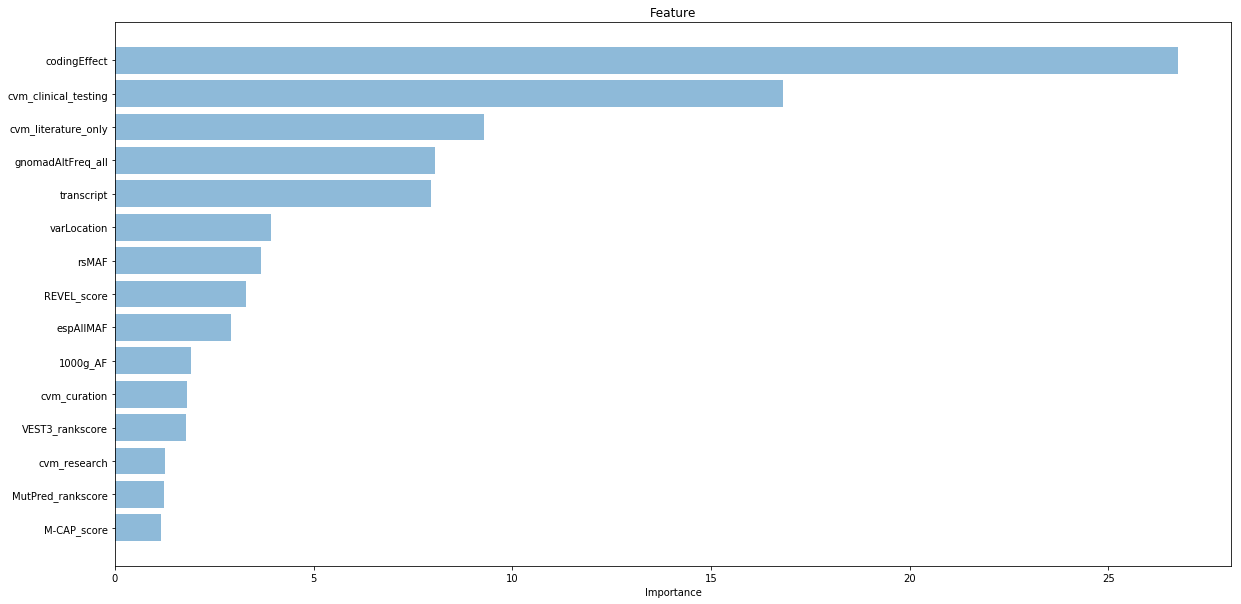

In [24]:
draw_importance(X_train.columns, model.feature_importances_, 
                save_path='feature_importance.png')

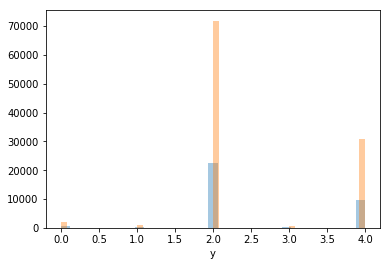

In [26]:
sns.distplot(y_test, kde=False);
sns.distplot(y_train, kde=False);

## Final flow

1. Filter out all `y` $\in [0, 1]$.
2. Sort `codingEffect` (all but misence) according to score values.
3. Sort all misence data (score) and append to back.

In [44]:
def final_order(df):
    df = df.copy()
    
    df['y'] = model.predict(df)[:, 0].astype(int)
    df = df[np.invert((df.y == 0) | (df.y == 1))]
#     del df['y']
    
    df['score'] = -calc_score(df)
    df['isCodingEffect'] = (df.codingEffect == 'missense').astype(int)
    df = df.sort_values(by=['isCodingEffect', 'score'])
    del df['score']
#     df['score'] = -df['score']
    del df['isCodingEffect']
    
    df.reset_index(drop=True, inplace=True)
    return df

In [45]:
final_order(X_test).head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_case-control,cvm_not_provided,cvm_literature_only,cvm_in_vivo,cvm_clinical_testing,cvm_phenotyping_only,cvm_provider_interpretation,cvm_research,cvm_curation,y
0,1,1273476.0,CA,C,NR_106866.1,NaN,downstream,p.?,NaN,NaN,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,4
1,1,1273478.0,GGGGGCAGCCGGGT,G,NM_004421.2,frameshift,exon,p.His502Profs*143,76.5833,9.80346,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,4
2,1,1273466.0,AC,A,NR_106866.1,NaN,downstream,p.?,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4
3,1,1273425.0,AA,G,NM_004421.2,frameshift,exon,p.Phe524Profs*125,90.0021,8.68007,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,4
4,X,48768775.0,GATCCCGACCTCCGCCTCCCATGCGACTGCTCGGGCAGACTGTCTC...,T,NM_001282651.1,frameshift,exon,p.Ala6Serfs*25,81.3480,7.62374,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4
